# Soluciones al examen de OPI 

In [86]:
# paquetes necesarios para este examen
import pandas as pd
from datetime import datetime # para que Python reconozca las fechas
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [346]:
# Función que se necesitará más adelante para agregar formato a la fec
def cambio_mes(mes):
    reemplazo = (
            ('Enero', '01'),
            ('Febrero', '02'),
            ('Marzo', '03'),
            ('Abril', '04'),
            ('Mayo', '05'),
            ('Junio','06'),
            ('Julio','07'),
            ('Agosto','08'),
            ('Septiembre','09'),
            ('Octubre', '10'),
            ('Noviembre','11'),
            ('Diciembre', '12')
        )
    for a, b in reemplazo:
        mes = mes.replace(a, b)
    return mes
cambio_mes.__doc__ = "Cambia el mes a su correspondiente valor numerico"

In [774]:
def seleccion_tiempo(datos, rango = 0):
    comp = datos['ao_hechos'] >= str(int(datos['ao_hechos'][-1]) - rango)
    datos_aux = datos[comp]
    return datos_aux
seleccion_tiempo.__doc__ = "Se seleccionan los datos de los últimos años, de acuerdo al rango dado."

def regresion_lineal(datos, rango = 0):
    datos = seleccion_tiempo(datos, rango)
    X = np.arange(len(datos.index))  # features
    y = datos['size']
    pendiente = linregress(X, y).slope
    return pendiente
regresion_lineal.__doc__ = "Regresa la pendiente de los datos seleccionados de acuerdo al rango de años dado."

def seleccion_delito(datos, lista):
    #comp = datos['delito'] == delito
    datos_aux = datos[datos['delito'] == lista]
    return datos_aux
seleccion_delito.__doc__ = "Se crea un subgrupo de los datos de acuerdo al delito elegido."

def alza_baja(datos, lista, rango = 0):
    lista_aux = []
    lista_total = []
    for delito in lista:
        datos_aux = seleccion_delito(datos, delito)
        tiempo = seleccion_tiempo(datos_aux, rango)
        pendiente = regresion_lineal(datos_aux, rango)
        if pendiente > 0:
            lista_aux.append('Alza')
        else:
            lista_aux.append('Baja')
    lista_total = lista_total + lista_aux
    #df = pd.DataFrame(lista_total)
    #df.set_index(lista, inplace = True)
    #df.columns = ['Tendencia durante los últimos '+ str(rango) + ' años']
    return lista_total
alza_baja.__doc__ = "De acuerdo al rango de años dado, se muestra en un Data Frame la tendencia para cada uno de los delitos registrados."

1. Los datos son de calidad cuando sirven para una finalidad prevista, basados en las siguientes características:
* No debe haber huecos, ni variables repetidas.
* La información debe ser relevante para cumplir los objetivos, por ejemplo, si estoy haciendo un análisis sobre los delitos en la ciudad de México, no me sirve tener información sobre el peso de los habitantes de la ciudad.
* Confiabilidad: hay que asegurarse que los datos no sean ambiguos, vagos o que contengan información contradictoria, por ejemplo, si tengo información sobre los delitos de una alcaldía en dos columnas y cada una con información diferente.
* Los datos tienen que ser colectados en el tiempo correcto, hay que asegurarse que no sean obsoletos, tomando de nuevo el análisis de los delitos de la CDMX, no tendría sentido que sólo tenga información de hace 30 años.

2. Datos a la alza y a la baja.

In [25]:
# importamos la base de datos
# encoding='utf-8' es para que al importarse la base de datos, reconozca caracteres 
# como la ñ.
# dtype='unicode' es para evitar un warning por low_memory ya que python estaba 
# adivinando el tipo de objeto (dtype) de cada columna

datos = pd.read_csv('/home/lorena/Escritorio/OPI/carpetas_completa_febrero_2022.csv', encoding='utf-8', dtype='unicode')

Para que las columnas fecha_hechos y fecha_inicia tal cual sean reconocidas como fechas, se utiliza la función de pandas **to_datetime**.

In [30]:
datos['fecha_hechos'] = pd.to_datetime(datos['fecha_hechos'], format = "%Y %m %d %H:%M:%S")
datos['fecha_inicio'] = pd.to_datetime(datos['fecha_inicio'], format = "%Y %m %d %H:%M:%S")

In [241]:
datos.set_index(datos['mes_hechos']+'/'+datos['ao_hechos'], inplace = True)

In [28]:
datos.columns

Index(['ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio', 'mes_inicio',
       'fecha_inicio', 'delito', 'fiscalia', 'agencia', 'unidad_investigacion',
       'categoria_delito', 'calle_hechos', 'calle_hechos2', 'colonia_hechos',
       'alcaldia_hechos', 'competencia', 'longitud', 'latitud', 'tempo'],
      dtype='object')

A continuación, descarto a aquellas filas en las que el año o la alcaldia de los hechos sea igual a **nan**:

In [725]:
es_nan_fecha = pd.isnull(datos['ao_hechos'])
es_nan_lugar = pd.isnull(datos['alcaldia_hechos'])
datos = datos[np.logical_not(np.logical_or(es_nan_fecha,es_nan_lugar))]

En el ejercicio se pide que se analice sólo los delitos ocurridos en la ciudad de México, así que el siguiente paso es descartar a aquellas locaciones que no pertenezcan a la ciudad.

Así que defino una función que seleccionará sólo a aquellos datos que hayan sido tomados en alguna alcaldía de la CDMX.

In [757]:
def seleccion_por_alcaldia(datos):
    
    alcaldias_cdmx = ['AZCAPOTZALCO', 'ALVARO OBREGON', 'BENITO JUAREZ', 'COYOACAN', 'CUAJIMALPA DE MORELOS','CUAUHTEMOC','GUSTAVO A MADERO', 'IZTACALCO', 'IZTAPALAPA', 'LA MAGDALENA CONTRERAS','MIGUEL HIDALGO','MILPA ALTA', 'TLALPAN','TLAHUAC','VENUSTIANO CARRANZA','XOCHIMILCO']
    
    lista = [locacion in alcaldias_cdmx for locacion in datos['alcaldia_hechos']]
        
    return datos[lista]

In [817]:
datos_filtrados = seleccion_por_alcaldia(datos)

Con la base agrupada, y con las observaciones nulas para la fecha y la alcaldia; agruparé a la base por fecha, para así calcular cuantas veces ocurren los delitos de acuerdo al año y mes.

In [818]:
delitos_fr = datos_filtrados.groupby(['delito','ao_hechos','mes_hechos'], as_index=False, group_keys=True).size()

En **delitos_fr** aplicamos la función **cambio_mes** para que fila a fila se cambie el formato del mes a numérico:

In [819]:
delitos_fr['mes_hechos'] = delitos_fr['mes_hechos'].apply(cambio_mes)

Para que sea más sencillos seleccionar la frecuencia de acuerdo al delito, hice una lista con el nombre de estos:

In [820]:
delitos = delitos_fr['delito'].unique()

Como índice para este nuevo DataFrame asignaré a la fecha, sólo año y mes, con esos dos datos temporales es suficiente en caso de que se requieran hacer gráficas.

In [821]:
delitos_fr.set_index(pd.to_datetime(delitos_fr['mes_hechos']+'/'+delitos_fr['ao_hechos'], format = '%m/%Y'), inplace = True)

## Prueba con un sólo delito

Antes de manipular los datos delito a delito, comencé con el primero del arreglo **delitos**. Así que primero seleccioné de **delitos_fr** el subgrupo del primer delito. 

In [769]:
primer_delito = delitos_fr[delitos_fr['delito'] == delitos[0]]

Para tener una idea de cómo se distribuyen los delitos a los largo del tiempo, se muestra la siguiente gráfica:

Hice una gráfica de la frecuencia para el primer delito, para confirmar que todo, está bien. **Nota**: más adelante si es necesario, quitaré esta gráfica.

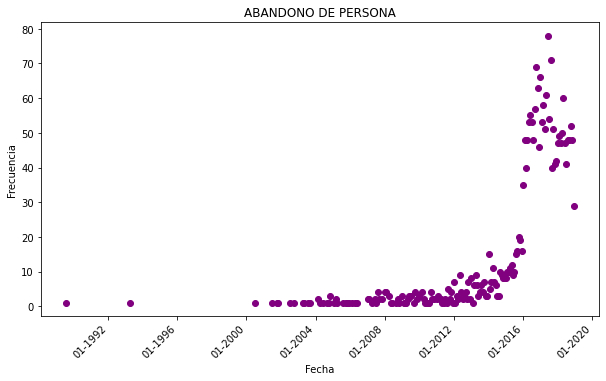

In [771]:
import matplotlib.dates as mdates # Intervalos de fecha
from matplotlib.dates import DateFormatter # para indicar el formato de fecha
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(primer_delito.index,
        primer_delito['size'],
        color='purple')
ax.set(xlabel="Fecha", ylabel="Frecuencia",
       title=delitos[0])

# Formato para el eje x
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(DateFormatter("%m-%Y"))
fig.autofmt_xdate(rotation=45)

plt.show()

### Regresion lineal 

Lo que queremos averiguar es si la ocurrencia de un delito ha ido a la alza o a la baja a lo largo del tiempo, esto se puede averiguar ajustando la ecuación de una recta a cada subgrupo de datos por delito, y una vez hecho, tomar el valor de la pendiente obtenida de esta ecuación; si la pendiente es positiva, quiere decir que hay una tendencia a la alta, en caso de ser negativa, la tendencia será a la baja.

### Rangos de tiempo 

En la gráfica de las ocurrencias del delito por abandono de persona, se observa que en los datos más viejos se tienen menos ocurrencias, así que si queremos analizar la tendencia con toda la base de datos, estas mediciones más viejas podrían darnos una idea errónea de lo que está ocurriendo. Para evitar eso, podemos revisar la tendencia en diferentes rangos de tiempo, por ejemplo, ver qué ha ocurrido en los últimos 15 años. 

In [ ]:
tendencia_completa = alza_baja(delitos_fr, delitos)
tendencia_15 = alza_baja(delitos_fr, delitos, 15)
tendencia_10 = alza_baja(delitos_fr, delitos, 10)
tendencia_5 = alza_baja(delitos_fr, delitos, 5)

A continuación muestro un DataFrame donde se encuentran las tendencias para todos los delitos, de acuerdo a los siguientes rangos de años: mediciones completas, últimos 15 años, últimos 10 años y últimos 5 años.

In [823]:
tendencias = pd.DataFrame()
tendencias['Todas_las_mediciones'] = tendencia_completa
tendencias['Ultimos_15_años'] = tendencia_15
tendencias['Ultimos_10_años'] = tendencia_10
tendencias['Ultimos_5_años'] = tendencia_5
tendencias.set_index(delitos, inplace = True)

In [824]:
tendencias

,Todas_las_mediciones,Ultimos_15_años,Ultimos_10_años,Ultimos_5_años
ABANDONO DE PERSONA,Alza,Alza,Alza,Alza
ABORTO,Baja,Alza,Alza,Baja
ABUSO DE AUTORIDAD,Alza,Alza,Alza,Alza
ABUSO DE AUTORIDAD Y USO ILEGAL DE LA FUERZA PUBLICA,Baja,Alza,Alza,Alza
ABUSO DE CONFIANZA,Alza,Alza,Alza,Alza
...,...,...,...,...
VIOLACION TUMULTUARIA,Alza,Alza,Alza,Alza
VIOLACION TUMULTUARIA EQUIPARADA,Baja,Alza,Alza,Alza
VIOLACION TUMULTUARIA EQUIPARADA POR CONOCIDO,Baja,Baja,Baja,Baja
VIOLACION Y ROBO DE VEHICULO,Baja,Baja,Baja,Baja


Podemos ver por ejemplo que en el caso de aborto:

In [784]:
tendencias.loc['ABORTO']

Todas_las_mediciones    Baja
Ultimos_15_años         Alza
Ultimos_10_años         Alza
Ultimos_5_años          Baja
Name: ABORTO, dtype: object

Si tomamos todas las mediciones, la tendencia es a la baja, al igual que en los últimos 5 años, sin embargo al analizar los últimos 15 y 10 años, este delito se fue a la alza. Así que para llegar a una mejor conclusión hay que analizar otros factores, como en qué alcaldías ocurrieron los delitos, el estatus socio económico de quien lo cometió, etc.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X = np.arange(len(primer_delito.index)).reshape((-1,1))  # features
y = primer_delito['size']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=primer_delito.index)

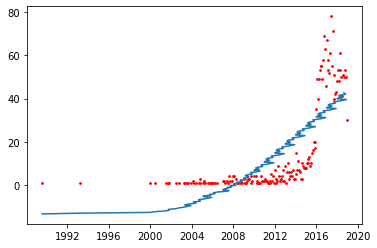

In [559]:
plt.plot(y_pred)
plt.scatter(primer_delito.index,primer_delito['size'], color = 'red', s = 3)
plt.show()

Abajo dejé algunos datos extras por si los necesito a futuro:

In [845]:
# arreglo con los años de los hechos que aparecen en la base de datos, sin repetir
año_hechos = sorted(datos_filtrados['ao_hechos'].unique())

In [846]:
año_hechos

['1906', '1915', '1917', '1930', '1942', '1950', '1952', '1954', '1955', '1956', '1957', '1958', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [57]:
# arreglo con los años de inicio que aparecen en la base de datos, sin repetir
año_inicio = datos['ao_inicio'].unique()

In [58]:
año_inicio

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)

3. Para averiguar el número de delitos por alcaldía, se puede agrupar la base de datos de acuerdo a esta variable, después, contar el número de delitos. 

In [825]:
datos_agrupados_alcaldia = datos_filtrados.groupby('alcaldia_hechos')

In [826]:
delitos_por_alcaldia = datos_agrupados_alcaldia.size()

In [827]:
max(delitos_por_alcaldia)

217938

In [828]:
comp_max = delitos_por_alcaldia == max(delitos_por_alcaldia)

In [829]:
delitos_por_alcaldia[comp_max]

alcaldia_hechos
CUAUHTEMOC    217938
dtype: int64

In [830]:
comp_min = delitos_por_alcaldia == min(delitos_por_alcaldia)

In [831]:
delitos_por_alcaldia[comp_min]

alcaldia_hechos
MILPA ALTA    10542
dtype: int64

La alcaldía Cuauhtémoc tiene una población de $545884$ habitantes, con una densidad de población de $16848$ habitantes por $km^2$ (fuente: [Wikipedia](http://es.wikipedia.org/wiki/Demarcaciones_territoriales_de_la_Ciudad_de_M%C3%A9xico "Wikipedia")), de hecho es la alcaldía con la mayor densidad poblacional. Por su parte, Milpa Alta tiene una población de $152 685$ habitantes, con una densidad población de $668$ habitantes por $km^2$, siendo la alcaldía con la menor densidad poblacional. Así que tan sólo el número de habitantes que hay en cada zona, y el cómo están distribuidas son factores importantes para esta incidencia de delitos.

Para entender un poco más sobre lo que pasa en la alcaldía Cuauhtémoc, podemos revisar cuáles son los delitos de mayor incidencia, y ver si existe alguna relación entre ellos.

Primero seleccionamos los datos de la alcaldía, después lo agrupamos por delitos.

In [807]:
delitos_cuauhtemoc = datos_agrupados_alcaldia.get_group('CUAUHTEMOC').groupby('delito')

Ahora, calculamos la ocurrencia de los delitos. A continuación se muestran los cinco delitos con mayor incidencia:

In [815]:
delitos_cuauhtemoc.size().nlargest()

delito
FRAUDE                                            22498
ROBO DE OBJETOS                                   15542
VIOLENCIA FAMILIAR                                12129
ROBO A NEGOCIO SIN VIOLENCIA                      11098
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA    10229
dtype: int64

Se observa que en estos delitos está implicado el robo.

4. Para revisar la tendencia estacional, me parece que lo mejor es analizar en rangos de años: los últimos 5, 10 y 15 años; a su vez, estos grupos se pueden estudiar en subgrupos de escalas de tiempo por quincenal, mensual, semestral y anual.

In [833]:
prueba = datos_filtrados[datos_filtrados['delito']==delitos[0]]

In [841]:
prueba.groupby(['fecha_hechos'], as_index=False, group_keys=True ).size()

,fecha_hechos,size
0,1989-08-25 12:00:00,1
1,1993-04-02 12:00:00,1
2,2000-07-05 12:00:00,1
3,2001-07-01 10:00:00,1
4,2001-10-26 12:00:00,1
...,...,...
1888,2018-12-26 12:28:00,1
1889,2018-12-26 19:30:00,1
1890,2018-12-27 13:42:00,1
1891,2018-12-27 23:00:00,1


In [848]:
año_hechos[-15:]

['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [851]:
prueba2 = datos_filtrados[datos_filtrados['ao_hechos']>='2008']

In [868]:
prueba3 = prueba2.groupby(['ao_hechos','mes_hechos','delito'], as_index = False, group_keys = True).size()

In [863]:
prueba3.nlargest()

ao_hechos  mes_hechos  delito            
2021       Marzo       VIOLENCIA FAMILIAR    3246
           Mayo        VIOLENCIA FAMILIAR    3197
           Abril       VIOLENCIA FAMILIAR    3157
           Octubre     VIOLENCIA FAMILIAR    2955
           Junio       VIOLENCIA FAMILIAR    2833
dtype: int64

In [870]:
prueba4 = datos_filtrados[datos_filtrados['ao_hechos']=='2008']

In [891]:
prueba5 = prueba4.groupby(['mes_hechos','delito'], as_index = False, group_keys = True).size()

In [892]:
prueba6 = prueba5[prueba5['mes_hechos'] == 'Abril']

In [915]:
prueba6.nlargest(5,'size')['delito']

12                    TORTURA
6                      FRAUDE
4          DENUNCIA DE HECHOS
7     INSOLVENCIA ALIMENTARIA
13                  VIOLACION
Name: delito, dtype: object

In [1035]:
def delitos_por_mes(mes):
    aux_df = pd.DataFrame()
    for año in range(2008,2022):
        comp_año = datos_filtrados['ao_hechos'] == str(año)
        datos_año = datos_filtrados[comp_año]
        delitos_agrupados_mes = datos_año.groupby(['mes_hechos','delito'], as_index = False, group_keys = True).size()
        delitos_mes = delitos_agrupados_mes[delitos_agrupados_mes['mes_hechos'] == mes]
        delitos_frec_mes = delitos_mes.sort_values('size', ascending = False)
        aux_df[str(año)] = delitos_frec_mes['delito']
    aux_df.reset_index(inplace = True)
    return aux_df
delitos_por_mes.__doc__ = "Muestra los delitos registrados durante los últimos 15 años para el mes dado, los delitos aparecen en orden de mayor ocurrencia en cada año."

In [1070]:
def frec_total_mes(mes):
    #meses_año = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
    df_mes = delitos_por_mes(mes)
    lista_aux = []
    for año in range(2008,2021):
        for delito in df_mes[str(año)]:
            if not pd.isna(delito): 
                lista_aux.append(delito)
    dic_aux = {i:lista_aux.count(i) for i in lista_aux}
    df_aux = pd.DataFrame(dic_aux.values(), index = dic_aux.keys(), columns = ['ocurrencia'])
    df_aux.sort_values('ocurrencia', ascending = False, inplace = True)
    return df_aux
frec_total_mes.__doc__ = "Regresa un DataFrame con todos los delitos ocurridos en los últimos 15 años para el mes dado, ordenados de acuerdo a la mayor ocurrencia"

In [1074]:
def frec_total_año():
    meses_año = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
    df_aux = pd.DataFrame()
    
    for mes in meses_año:
        delitos_mes = frec_total_mes(mes)
        df_aux[mes] = delitos_mes.index
    return df_aux